In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
import DataLoader

In [2]:
# test_data = pd.read_json("data/test_data_100.json").iloc[0].to_dict()["recipes"]
# test_data = { int(recipe_id): info for recipe_id, info in test_data.items()}


# with open("data/all_recipes_original.pkl", "rb") as infile:
#     data = pickle.load(infile)

# cleaned_data = {}
# for recipe_id, info in data.items():
#     info["user ratings"] = {int(id): rating for id, rating in info["user ratings"].items()}
#     cleaned_data[int(recipe_id)] = info
# with open("data/all_recipes.pkl", "wb") as out:
#     pickle.dump(cleaned_data, out)
    
# Extract user ratings to matrix from test data
# def extract_user_ratings(data):
#     ratings_data = []
#     for recipe_id, attributes in data.items():
#         if "user ratings" in attributes:
#             for user_id, rating in attributes["user ratings"].items():
#                 ratings_data.append((int(user_id), int(recipe_id), rating))
#     return pd.DataFrame(ratings_data, columns=["user_id", "recipe_id", "rating"])

In [3]:
# Ratings Only
# with open("data/user_dict.pkl", "rb") as infile:
#     user_data = pickle.load(infile)

# ratings = pd.read_csv("data/all_recipe_clean.csv")

# Full Recipe
with open("data/all_recipes.pkl", "rb") as infile:
    recipes = pickle.load(infile) 
ratings = pd.read_csv("data/all_ratings.csv")

recipe_rating_counts = ratings.recipe_id.value_counts()
recipe_ids = recipe_rating_counts[recipe_rating_counts >= 5].index.unique().values
recipe_ids = frozenset(recipe_ids)
ratings_filtered = ratings[ratings.recipe_id.isin(recipe_ids)]
ratings = ratings_filtered

In [4]:
print("Ratings Data")
print("Number of Ratings: {}".format(len(ratings)))
print("Number of Recipes: {}".format(len(ratings.recipe_id.value_counts())))
print("Number of Users: {}".format(len(ratings.user_id.value_counts())))
print("Average Rating: {0:.3f}".format(ratings.rating.mean()))

# ratings

Ratings Data
Number of Ratings: 184437
Number of Recipes: 22515
Number of Users: 120999
Average Rating: 4.359


[1 2 3 4 5]


Text(0.5, 0, 'Rating')

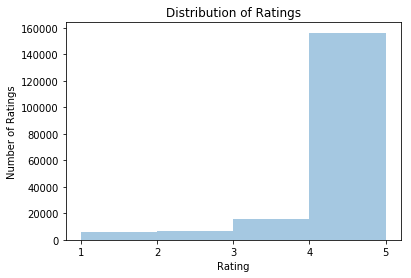

In [13]:
# TODO: Distribution of recipe ratings
# ratings.recipe_id.value_counts()

#TODO: Distribution of user ratings


# Distribution of Ratings
rating_values = ratings.rating.values
bins = np.arange(rating_values.min(), rating_values.max() + 1)
print(bins)
ax = sns.distplot(rating_values, kde=False, bins=bins)
ax.set_xticks(bins)
ax.set_title("Distribution of Ratings")
ax.set_ylabel("Number of Ratings")
ax.set_xlabel("Rating")

Text(0.5, 1.0, 'Average Recipe Ratings Distribution')

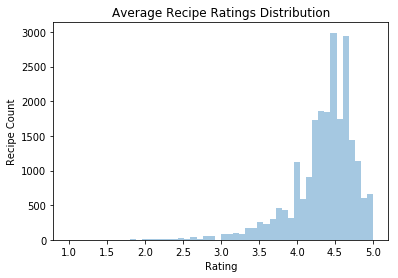

In [6]:
recipe_ratings = ratings.groupby("recipe_id").rating.mean()
ax = sns.distplot(recipe_ratings, kde=False)
ax.set_ylabel("Recipe Count")
ax.set_xlabel("Rating")
ax.set_title("Average Recipe Ratings Distribution")

Text(0.5, 0, 'Number of Ratings given to Recipe')

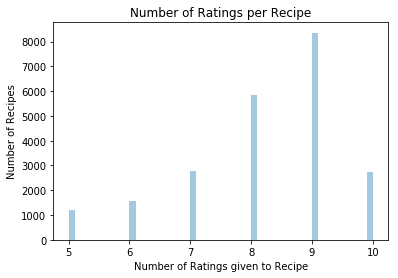

In [7]:
# Ratings counts
ax = sns.distplot(ratings.recipe_id.value_counts().values, kde=False)
ax.set_title("Number of Ratings per Recipe")
ax.set_ylabel("Number of Recipes")
ax.set_xlabel("Number of Ratings given to Recipe")

In [10]:
# User Ratings
# ax = sns.distplot(ratings.user_id.value_counts().values, kde=False)
# ax = sns.boxplot(x=ratings.user_id.value_counts().values)
# print("Number of ratings per user")
# ratings.user_id.value_counts().describe()

# recipe_ratings = ratings_filtered.groupby("recipe_id").rating.mean().values
# ax = sns.distplot(recipe_ratings, kde=False)
# ax.set_title("Filtered Recipe Ratings Distribution")
# ax.set_xlabel("Rating")
# ax.set_ylabel("Recipe Count")

# from collections import Counter
# Counter(ratings.user_id.value_counts().values)

np.sum(ratings.user_id.value_counts().values >= 3)

9564

In [9]:
# user_rating_counts = ratings.user_id.value_counts()
# user_rating_counts = user_rating_counts[user_rating_counts >= 3]

# train_users, test_users = train_test_split(ratings.user_id.unique(), test_size=0.2, random_state=0)

# ratings.user_id.unique()
# test_users.shape
# 
# user_rating_counts[user_rating_counts >= 3].index.unique().values

# np.sum(ratings.recipe_id.value_counts() >= 5)

# ratings_filtered = ratings[ratings.user_id.isin(frozenset(train_users))]

# ratings_filtered.groupby("recipe_id").user_id.apply(np.array)

# ratings_filtered.groupby("user_id").recipe_id.apply(set)

In [132]:
# ratings_filtered[ratings_filtered.recipe_id == 5].user_id
# ratings_dict = ratings_filtered.groupby(["user_id", "recipe_id"]).rating.apply(sum)

ratings_dict[8][194]

4

In [4]:
dataLoader = DataLoader.DataLoader(ratings)
user_holdout, recipe_holdout, holdout = dataLoader.get_holdout_data()
# for user_id, user_recipes in dataLoader.user_to_recipes_train.items():
# #     print(user_id, user_recipes)
#     hidden_recipe_id = np.random.choice(user_recipes)
#     print(hidden_recipe_id)

# dataLoader.all_ratings[4]

In [5]:
# dataLoader.get_user_ratings(4, user_holdout)
dataLoader.get_recipe_ratings(2843, recipe_holdout)
# r2r = dataLoader.recipe_to_raters_train
# huid = recipe_holdout[2843]
# raters = r2r[2843]

# for uid in raters:
#     print(uid)
#     print(dataLoader.all_ratings[uid][2843])
#     print(uid, dataLoader.all_ratings[uid][2843])
#     print(uid, dataLoader.all_ratings[uid])
# dataLoader.recipe_to_raters_train

# r2r = ratings[~ratings.user_id.isin(frozenset(dataLoader.test_users))].groupby("recipe_id").user_id.apply(list)

# recipe_holdout[2843]

# {user_id : {k[1]: rating for recipe_id, rating in v.items()} for k, rating in dataLoader.all_ratings.items()}

# ratings_dict = defaultdict(dict)
# for k, rating in dataLoader.all_ratings.items():
#     user_id, recipe_id = k
#     ratings_dict[user_id][recipe_id] = rating

# dataLoader.all_ratings

# for user_id, recipe_id, rating in holdout:
# #     print(recipe_id, len(dataLoader.get_recipe_ratings(recipe_id, recipe_holdout)))
#     if len(dataLoader.get_recipe_ratings(recipe_id, recipe_holdout)) == 0:
#         print(recipe_id)

{5890: 5,
 27395: 5,
 27140: 2,
 50693: 5,
 4: 5,
 44551: 5,
 36360: 5,
 11012: 5,
 65797: 4,
 32520: 5,
 17420: 4,
 52489: 5,
 31247: 5,
 64017: 4,
 39189: 5,
 8738: 5,
 42274: 5,
 59683: 4,
 55076: 5,
 8485: 1,
 77095: 4,
 85288: 3,
 48423: 5,
 33328: 4,
 70447: 5,
 34866: 1,
 63281: 5,
 20792: 5,
 58943: 5,
 52031: 5,
 36417: 5,
 37187: 4,
 38984: 5,
 18254: 4,
 13136: 5,
 54098: 5,
 83294: 4,
 24415: 5,
 33383: 5,
 7272: 4,
 79208: 4,
 44393: 5,
 36459: 3,
 25709: 5,
 30574: 5,
 28790: 5,
 73335: 5,
 73592: 1,
 2424: 5,
 2685: 5,
 41603: 5,
 85637: 5,
 6027: 5,
 87436: 5,
 20363: 4,
 16018: 5,
 64916: 4,
 53403: 4,
 27038: 5,
 5287: 5,
 67497: 4,
 41903: 5,
 13231: 5,
 16563: 3,
 39605: 5,
 82110: 5,
 39616: 5,
 7361: 5,
 63686: 4,
 55245: 5,
 19410: 5,
 24020: 5,
 27606: 5,
 13786: 4,
 62943: 4,
 38115: 5,
 49639: 5,
 28395: 5,
 71659: 4,
 73967: 4,
 59632: 5,
 4336: 5,
 61168: 5,
 65780: 5,
 87031: 5,
 251: 3,
 78590: 4,
 19455: 3}